<a href="https://colab.research.google.com/github/karimtito/Machine_learning_NLP_Yelp/blob/master/Sentiment_analysis_Yelp_ENSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Importing required librairies, loading and quickly exploring the data 


In [19]:
import pandas as pd                         #used to load csv files and 
import numpy as np
import re                                   #regular expressions use to clean the text
import string
from tqdm import tqdm
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('wordnet')
import spacy
tokenizer = spacy.load("en_core_web_sm")
import os
import random                               # to randomly sample lines in the yelp data set
n = 30000                                 #total number of observations
s = 10000                       #number of samples
prop_train_test = 0.9                          #proportion of samples for training and testing vs. validation
prop_train = 0.8                               #proportion of samples for training vs. testing
index = random.sample(range(1,n+1),n-s)


import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("https://raw.githubusercontent.com/karimtito/Machine_learning_NLP_Yelp/master/yelp_review_30K.csv",skiprows = index)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
%load_ext autoreload
%autoreload 2

import torch                                # Importation of PyTorch to train the LSTM
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1)

from sklearn.tree import plot_tree                          #used to plot the tree
from sklearn.metrics import confusion_matrix                #use the obtain ROC and other metrics for all the models


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#import zipfile
#import io
#zf = zipfile.ZipFile(io.BytesIO(uploaded['yelp_30K.zip']), "r")
#zf.extractall()

In [22]:
positive_review = lambda x : np.heaviside(x-3,1)         
#Nota Bene: to simplify we use '1' for a positive review and '0' for a negative review, even though we are more interested in the 
#performance for labelling negative reviews i.e. to detect them well
labels = np.array(df["stars"].apply(positive_review))
df["label"] = labels
pos_freq = labels.mean()                         #sample frequency of positive reviews
df.head(10),labels.mean()  #we look at the 10 first rows and at the sample frequency of positive reviews


(   Unnamed: 0  stars                                               text  label
 0           4      4  Had their chocolate almond croissant and it wa...    1.0
 1           5      5  Cycle Pub Las Vegas was a blast! Got a groupon...    1.0
 2          12      1  I thought Tidy's Flowers had a great reputatio...    0.0
 3          14      5  This place is awesome! Definitely authentic!!!...    1.0
 4          15      4  a must stop when you are in montreal!\n\nI was...    1.0
 5          19      1  really excited to hear of this restaurant comi...    0.0
 6          24      3  While looking at different restaurants in the ...    1.0
 7          27      5  OMG - Definitely worth going if you are in Mon...    1.0
 8          29      4  Love the selection of winter gear here for my ...    1.0
 9          32      4  Decided to try this place after reading the re...    1.0,
 0.7971)

We see that there is a pretty big imbalance : 80% of positive reviews /20% of negative reviews


> One thing that can be done to improve on that is to sample weights in the training of algorithms

The idea is to consider a weighted version of the empirical loss $l_{n,\omega}(f,D_n) = \sum_{i :Y_i = 0}\omega_{0}l(f(X_i),Y_i)+\sum_{i :Y_i = 1}\omega_{1}l(f(X_i),Y_i)$, with the condition $\omega_{0}\#\{i :Y_i = 0\}+\omega_{1}\#\{i :Y_i = 1\}=1$. For example one can take $\omega_0 = (1-N_1/n)/N_0$ and $\omega_1 = \frac{1}{n}$. We use this approach to train the CART algorithm with Bag-of-words.




Below we drop unecessary/unusable columns and rows and we get the training, testing and validation labels.

In [23]:
df2 =df.drop(labels = ['Unnamed: 0', 'stars'],axis =1)
print(df2.shape)
df2.dropna()
Y = df2.label.to_numpy()
n_train_test = int(s*prop_train_test)
n_train = int(n_train_test*prop_train)
Y_train,Y_test,Y_validation = Y[:n_train],Y[n_train:n_train_test],Y[n_train_test:]

(10000, 2)


In [0]:
sample_weights = (1./s)*np.ones(s)
N_0,N_1 = s-Y.sum(),Y.sum()
sample_weights[Y==0] = (1-N_1/n)/N_0

# Wordcloud visualization:
A visualization method that displays how frequently words appear in a given body of text, by making the size of each word proportional to its frequency. All the words are then arranged in a cluster or cloud of words.

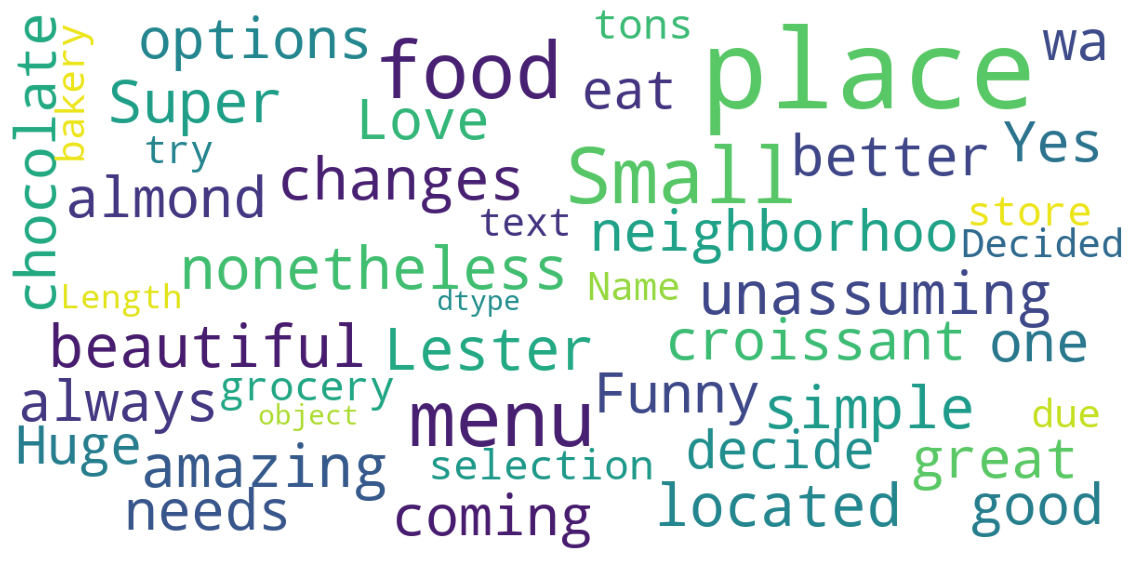

In [0]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df2["text"])

## 2. Implementation of LSTM with Word2vec embedding
We begin by cleaning the corpus of reviews and training a Word2Vec embedding.

In [140]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')



def tokenized_sentence(corpus):
  tokenizer = TreebankWordTokenizer()
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      remove = string.punctuation
      pattern = r"[{}]".format(remove)
      tokens = list(map(lambda x: re.sub(pattern,"", x.lower().rstrip()) , tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

def clean_corpus(corpus, threshold=100):
  tokenized_sentences = tokenized_sentence(corpus)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus


corpus = clean_corpus(df2.text.array[:n_train])
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))


  0%|          | 99/21600 [00:00<00:21, 983.33it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 21600/21600 [00:32<00:00, 663.12it/s]


The virtual instance has 2 cpus, that will be used to train the word2vec model


In [141]:
corpus[1237]

['nothing',
 'too',
 'outside',
 'of',
 'the',
 'box',
 'but',
 'that',
 's',
 'not',
 'necessarily',
 'a',
 'bad',
 'thing']

We now train the Word2Vec representation on our cleaned corpus.

In [0]:
model = Word2Vec(corpus, size=500, window=5, min_count=3, workers=cpu)
model.train(corpus, total_examples=len(corpus), epochs=10)
model_wv = model.wv

In [143]:
model_wv.save("./word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We next check qualitatively the relevance of the Word2vec embeding

In [0]:
def most_similar(w,n=5):
  if w in model_wv:
    closest_ws =[w[0] for w in model_wv.most_similar(w, topn=n)]
    print("According to our ad-hoc Word2vec, the closest {}, words to \"{}\" " 
    "are: \n {}".format( n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
  else:
    print(w, " could not be found in the Word2vec vocabulary")

In [145]:
most_similar("restaurant")
most_similar("amazing")
most_similar("confusing")

According to our ad-hoc Word2vec, the closest 5, words to "restaurant" are: 
 "establishment",
 then "place",
 then "theater",
 then "restaurants",
 then "joint"
According to our ad-hoc Word2vec, the closest 5, words to "amazing" are: 
 "awesome",
 then "incredible",
 then "fantastic",
 then "excellent",
 then "outstanding"
According to our ad-hoc Word2vec, the closest 5, words to "confusing" are: 
 "annoying",
 then "frustrating",
 then "chaotic",
 then "offputting",
 then "tricky"


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


The embedding seems good enough to train directly an LSTM network on top of it.

### 2.2 Training an LSTM with the trainded Word2Vec embedding

We first write a function to embed any sequence using the above Word2Vec model

In [0]:
def prepare_embedding(seq, embedding = ):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

## 3. Classification decision trees with Bag-of-Words features




We now use impelment a Bag of Words approach. We first tokenize each review and we also use the tokenized whole corpus to define a dictionnary.

In [207]:
#we begin by lowering the review, removing the line breaks and numbers
df2.text = df2.text.apply(lambda x: re.sub(r'[0-9]+', '', x.lower().rstrip())) 

x = df2.text.to_numpy()
df2.head()

,text,label
0,super simple place but amazing nonetheless. it...,1.0
1,small unassuming place that changes their menu...,1.0
2,lester's is located in a beautiful neighborhoo...,1.0
3,love coming here. yes the place always needs t...,1.0
4,had their chocolate almond croissant and it wa...,1.0


We then build the Bag-of-words features of the text using a feature extractor from Scikit-learn.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
nb_max_feat = 3000
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = 'english', max_features = nb_max_feat) 
train_data_features = vectorizer.fit_transform(x)
z =vectorizer.transform([df2.text.array[6]]).toarray()
nb_feat = z.shape[0]

In [0]:
X = train_data_features.toarray()
X_train,X_test,X_validation= X[:n_train],X[n_train:n_train_test],Y[n_train_test:]


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(max_depth=5,random_state= 0)

clf = clf.fit(X_train,Y_train)

In [0]:
Y_hat_test2 = clf.predict(X_test)
C = confusion_matrix(Y_test,Y_hat_test2)

In [0]:
neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
fpr = C[0,1]/(C[0,1]+C[1,1])
tpr = C[ 1,1]/(C[1,1]+C[0,1])
neg_pred_perf,fals_disc_rate

(0.8675213675213675, 0.9925355164941007)

We see that naively training a decision tree with a maximum depth of 5, we already have pretty good results according to our metrics.
Since training the decision trees is not too costly, we can proceed to a model selection on the depth of the tree using the test set.

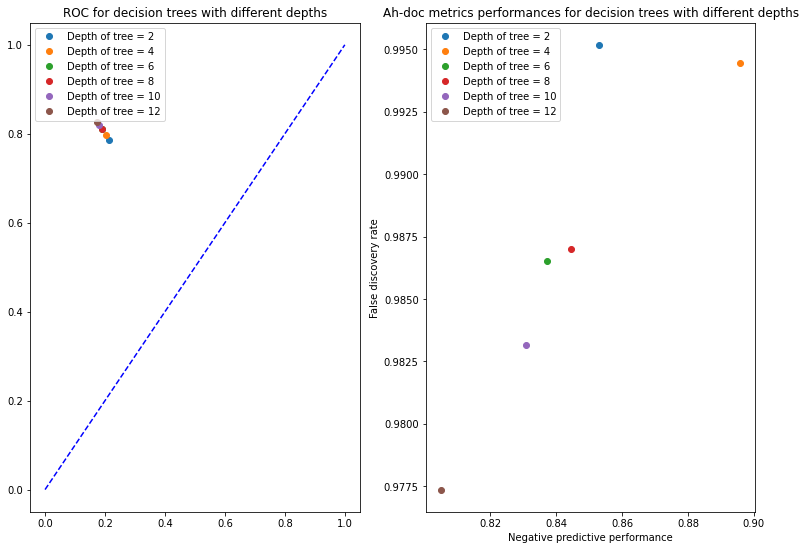

In [0]:
range_depth = np.arange(2,14,2)
neg_pred_ = []
false_disc_ = []
fpr_ = []
tpr_ = []
T = np.linspace(0,1,100)
plt.figure(figsize=( 13,9))
plt.subplot(1,2,1)
plt.plot(T,T,'b--')
for d in range_depth:
  clf = DecisionTreeClassifier(max_depth=d,random_state=0)
  clf = clf.fit(X_train,Y_train)
  Y_hat_test = clf.predict(X_test)
  C = confusion_matrix(Y_test,Y_hat_test)
  neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
  fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
  fpr = C[0,1]/(C[0,1]+C[1,1])
  tpr = C[ 1,1]/(C[1,1]+C[0,1])
  neg_pred_.append(neg_pred_perf)
  false_disc_.append(fals_disc_rate)
  fpr_.append(fpr)
  tpr_.append(tpr)
  plt.plot(fpr,tpr,'o',label = "Depth of tree = {}".format(d))

plt.legend()
plt.title("ROC for decision trees with different depths")
plt.savefig("ROC_CART")
plt.subplot(1,2,2)
plt.xlabel("Negative predictive performance")
plt.ylabel("False discovery rate")
for i in range(len(range_depth)):
  d=range_depth[i]
  plt.plot(neg_pred_[i],false_disc_[i],'o',label = "Depth of tree = {}".format(d))

plt.legend()
plt.title("Ah-doc metrics performances for decision trees with different depths")
plt.savefig("adhocCART")






We see that overall the decision trees have pretty good perfomances. We see that the ROC improves gradually as depth is increased. On the others hand, for the metrics we chose to focus on, we see that the perfomances seems to decrease for larger models. Given the perfomances, we choose to use a depth of *4* for the validation. \\
We next plot the decision tree obtained for $depth = 4$.

[Text(418.5, 679.5, 'X[2241] <= 0.5\ngini = 0.308\nsamples = 21600\nvalue = [4114, 17486]'),
 Text(209.25, 407.69999999999993, 'X[183] <= 0.5\ngini = 0.294\nsamples = 21175\nvalue = [3789, 17386]'),
 Text(104.625, 135.89999999999998, '\n  (...)  \n'),
 Text(313.875, 135.89999999999998, '\n  (...)  \n'),
 Text(627.75, 407.69999999999993, 'X[1549] <= 0.5\ngini = 0.36\nsamples = 425\nvalue = [325, 100]'),
 Text(523.125, 135.89999999999998, '\n  (...)  \n'),
 Text(732.375, 135.89999999999998, '\n  (...)  \n')]

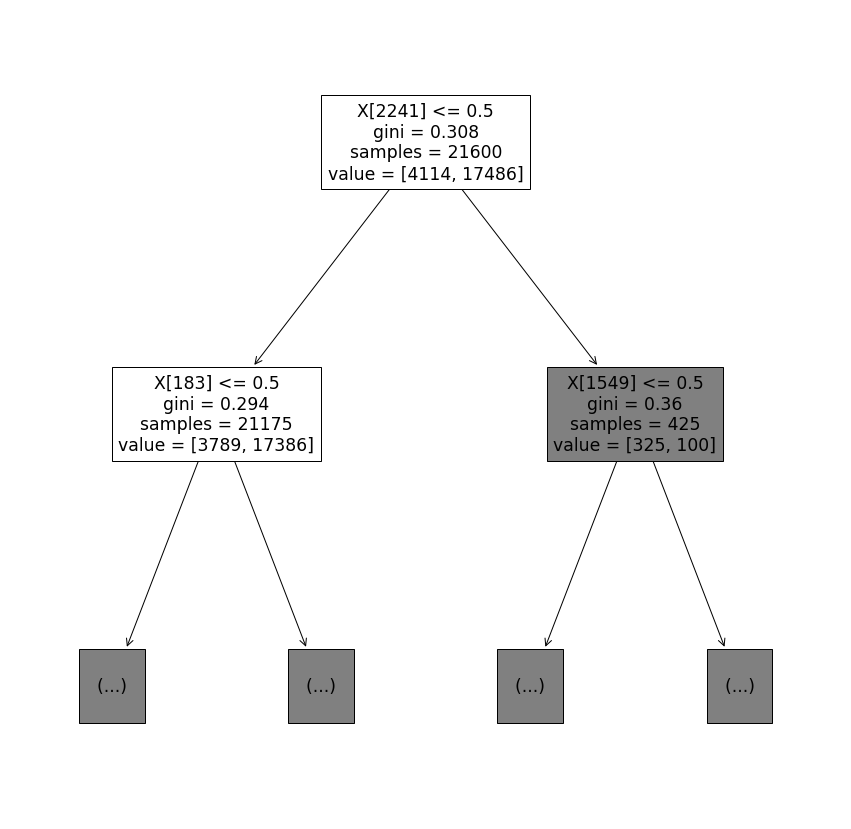

In [0]:

clf = DecisionTreeClassifier(max_depth=4,random_state=0)
plt.figure(figsize=(15, 15))
plot_tree(clf.fit(X_train,Y_train),max_depth=1) 

To interprete the tree plot we determine the word associated with each of the 3 first nodes. 

In [0]:
X = np.zeros(3000)
X[2241] = 1
vectorizer.inverse_transform(X)  # we use the inverse transform of the Bag-of-words feature extractor above

[array(['rude'], dtype='<U15')]

In [0]:
X = np.zeros(3000)
X[183] = 1
vectorizer.inverse_transform(X)

[array(['bad'], dtype='<U15')]

In [0]:
X = np.zeros(3000)
X[1549] = 1
vectorizer.inverse_transform(X)

[array(['love'], dtype='<U15')]

Here we see that the most important for the model are "rude", "bad" and "love", which makes sense qualitatively.

## 4 Training an LSTM nn with it's own embedding layer

### Building the features for the model

In [0]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



def clean_tokenized_text(text):
    #Ad-hoc cleaning and tokenizing of the text
    # lower text
    text = text.lower()
    # remove line jumps and tabs
    text = text.replace("\n", '').replace('\r', '').replace('\t','').replace("\\/",'-').replace("!",' ').replace(".",' ').replace(",","" ")
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]           # The character "'" is not considered as punctation
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]      
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]   # we are not interested in one-character expressions such as 'a' or '&'
    # join all
    return(text)   



In [0]:
df2.text=df["text"].apply(lambda x: clean_tokenized_text(x))


In [10]:
"eerj j \n stuff\n".replace("\n",'')

'eerj j  stuff'

In [28]:
df2.text.head(10)

0    [chocolate, almond, croissant, amazing, light,...
1    [cycle, pub, la, vega, blast, get, groupon, re...
2    [think, tidy's, flower, great, reputation, flo...
3    [place, awesome, definitely, authentic, two, f...
4    [must, stop, montreal, mtl, weekend, wind, eat...
5    [really, excited, hear, restaurant, come, toro...
6    [look, different, restaurant, area, come, upon...
7    [omg, definitely, worth, go, montreal, remembe...
8    [love, selection, winter, gear, little, one, b...
9    [decide, try, place, read, review, disappoint,...
Name: text, dtype: object

In [29]:
x = df2.text.to_numpy()
data = []
for i in range(len(x)):
    data.append((x[i], Y[i]))
training_data = data[:n_train]
test_data = data[n_train:n_train_test]
validation_data = data[n_train_test:]
print("Got {} training samples, {} test samples, {} validation samples".format(len(training_data), len(test_data),len(validation_data)))


Got 7200 training samples, 1800 test samples, 1000 validation samples


In [0]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

word_to_ix = {}
tag_to_ix = {}
for review, tag in training_data:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)
    for word in review:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)



In [31]:
training_data[6]

(['look',
  'different',
  'restaurant',
  'area',
  'come',
  'upon',
  'restaurant',
  'posting',
  'decide',
  'try',
  'street',
  'work.not',
  'bad',
  'want',
  'something',
  'slightly',
  'cheap',
  'congee',
  'star',
  'mix',
  'chinese',
  'choy',
  'suey',
  'menu'],
 1.0)

In [0]:
# defining the classifier model

class SequenceLabeller(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes, sequence_model="LSTM"):
        super(SequenceLabeller, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        if sequence_model == "LSTM":
            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.seq = nn.LSTM(embedding_dim, hidden_dim,batch_first=True,bi)
        else:
            raise(Exception("Sequence model {} not supported".format(sequence_model)))

        # The linear layer that maps from hidden state space to class space
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        seq_output, (h_n,c_n) = self.seq(embeds)
        tag_space = self.hidden2tag(seq_output)
        # Although we will be performing binary classification, this is a 
        # general implementation displaying what should be done for n_classes>2
        tag_scores = F.log_softmax(tag_space, dim=2) # Computationally efficient for the criterion
        return tag_scores

We run once the model on the first review.

In [33]:
# the additional vocabulary element is to account for unkown words
model = SequenceLabeller(50, 100, len(word_to_ix)+1, len(tag_to_ix)) 
inputs = prepare_sequence(training_data[0][0], word_to_ix)
with torch.no_grad():
    sent_scores = model(torch.cat([inputs]))
    print("Input tokens {} scores {} ".format(inputs, sent_scores))

Input tokens tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  4,  9, 10, 11, 12, 13, 14, 15, 16]]) scores tensor([[[-0.7342, -0.6537],
         [-0.7592, -0.6312],
         [-0.7435, -0.6452],
         [-0.7648, -0.6263],
         [-0.7850, -0.6090],
         [-0.7261, -0.6613],
         [-0.7165, -0.6703],
         [-0.7346, -0.6533],
         [-0.7575, -0.6327],
         [-0.7671, -0.6243],
         [-0.6952, -0.6911],
         [-0.7072, -0.6793],
         [-0.7006, -0.6858],
         [-0.7557, -0.6343],
         [-0.7837, -0.6102],
         [-0.7457, -0.6432],
         [-0.7582, -0.6321],
         [-0.7308, -0.6568]]]) 


In [34]:
model

SequenceLabeller(
  (word_embeddings): Embedding(31138, 50)
  (seq): LSTM(50, 100, batch_first=True)
  (hidden2tag): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

### 4.3 Training of the model

In [45]:
from torch.nn.functional import one_hot
n_epochs = 100
for epoch in range(n_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_mean_ep = 0
    n_sample = 0
    for sentence, tags in training_data:
        if len(sentence) < 2: continue
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #import pdb
        #pdb.set_trace()
        targets = prepare_sequence([tags], tag_to_ix)
        one_hot_targets = one_hot(targets.squeeze(0), num_classes=len(tag_to_ix))
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        #import pdb
        #pdb.set_trace()
        # print(tag_scores.shape, one_hot_targets.shape)
        loss = loss_function(tag_scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1
        loss.backward()
        optimizer.step()
    print("Epoch {} loss {:0.4f} ".format(epoch, loss_mean_ep/n_sample))

Epoch 0 loss 0.2432 
Epoch 1 loss 0.2416 
Epoch 2 loss 0.2401 
Epoch 3 loss 0.2387 
Epoch 4 loss 0.2374 
Epoch 5 loss 0.2362 
Epoch 6 loss 0.2350 
Epoch 7 loss 0.2339 
Epoch 8 loss 0.2329 
Epoch 9 loss 0.2319 
Epoch 10 loss 0.2310 
Epoch 11 loss 0.2301 
Epoch 12 loss 0.2292 
Epoch 13 loss 0.2284 
Epoch 14 loss 0.2276 
Epoch 15 loss 0.2269 
Epoch 16 loss 0.2262 
Epoch 17 loss 0.2255 
Epoch 18 loss 0.2249 
Epoch 19 loss 0.2243 
Epoch 20 loss 0.2237 
Epoch 21 loss 0.2231 
Epoch 22 loss 0.2225 
Epoch 23 loss 0.2220 
Epoch 24 loss 0.2215 
Epoch 25 loss 0.2210 
Epoch 26 loss 0.2205 
Epoch 27 loss 0.2201 
Epoch 28 loss 0.2196 
Epoch 29 loss 0.2192 
Epoch 30 loss 0.2188 
Epoch 31 loss 0.2183 
Epoch 32 loss 0.2180 
Epoch 33 loss 0.2176 
Epoch 34 loss 0.2172 
Epoch 35 loss 0.2168 
Epoch 36 loss 0.2165 
Epoch 37 loss 0.2161 
Epoch 38 loss 0.2158 
Epoch 39 loss 0.2155 
Epoch 40 loss 0.2152 
Epoch 41 loss 0.2149 
Epoch 42 loss 0.2146 
Epoch 43 loss 0.2143 
Epoch 44 loss 0.2140 
Epoch 45 loss 0.2137

In [0]:
torch.save(model.state_dict(),'.\lstm2')